In [5]:
import json
import pandas as pd
import plotly.express as px

In [68]:
def read_file(path):
    with open(path, "r") as f:
        return json.loads(f.read())["results"]


def short_name(name):
    if "/" in name:
        name = name.split("/")[1]
    for k in ["-Instruct", "-preview"]:
        if k in name:
            name = name.split(k)[0]
    return name

In [90]:
data = []
fnames = [
    "full_run_outputs/250109T1800.json",
    "full_run_outputs/250109T1802.json",
    "full_run_outputs/250109T1803.json",
    "full_run_outputs/250109T1804.json",
    "full_run_outputs/250109T1806.json",
    "full_run_outputs/250109T1808.json",
    #    "full_run_outputs/250108T2041.json",
]

data2 = []

for fname in fnames:
    for key, value in read_file(fname).items():
        x = key.split("|")
        name, fromtype = x[0].split("---DESCRIPTION-")
        desc_model = x[1].split("---COMPARISON")[0]
        cmp_model = x[2]
        values = value["total_tallies"]
        desc_model = short_name(desc_model)
        cmp_model = short_name(cmp_model)
        row = (name, fromtype, desc_model, cmp_model)
        data.append(row + ("human", values["Human"]))
        data.append(row + ("llm", values["LLM"]))
        data.append(row + ("invalid", values["Invalid"]))

        total = values["Human"] + values["LLM"] + values["Invalid"]
        data2.append((desc_model, cmp_model, fromtype, float(values["Human"]) / total))
df = pd.DataFrame(data, columns=["name", "ftype", "desc_model", "cmp_model", "rtype", "rvalue"])
df.cmp_model.unique()

array(['Meta-Llama-3.1-70B', 'Mixtral-8x22B', 'Qwen2.5-72B',
       'gpt-3.5-turbo', 'gpt-4-1106', 'Qwen2.5-7B'], dtype=object)

In [99]:
df2 = pd.DataFrame(data2, columns=["desc_model", "cmp_model", "ftype", "value"])
df2 = df2[df2.ftype == "from_json_details"].pivot(index='desc_model', columns='cmp_model', values='value')
df2

TypeError: DataFrame.__init__() got an unexpected keyword argument 'text_auto'

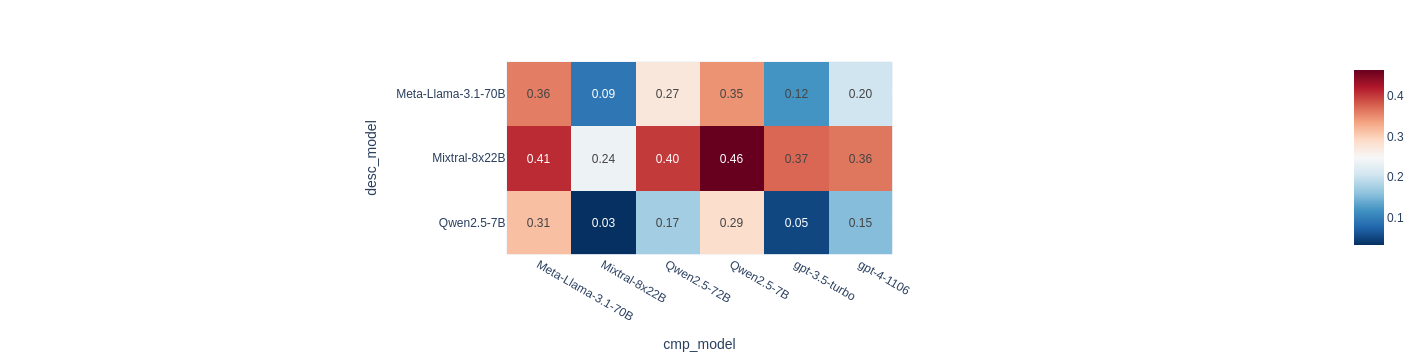

In [103]:
px.imshow(df2, text_auto=".2f", color_continuous_scale='RdBu_r')

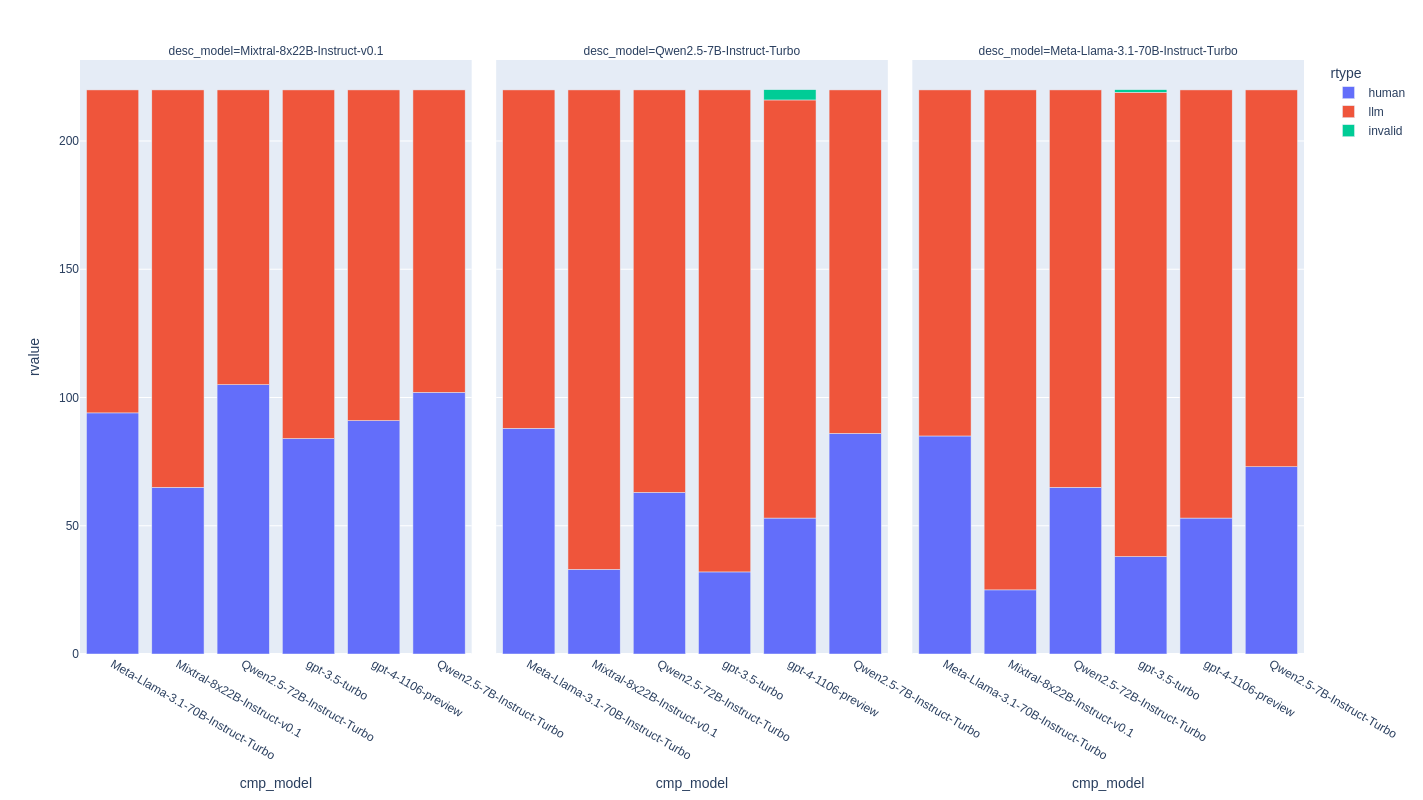

In [60]:


px.bar(df[df.ftype=="from_json_product_listing"], x="cmp_model", y="rvalue", facet_col="desc_model", height=800, color="rtype")

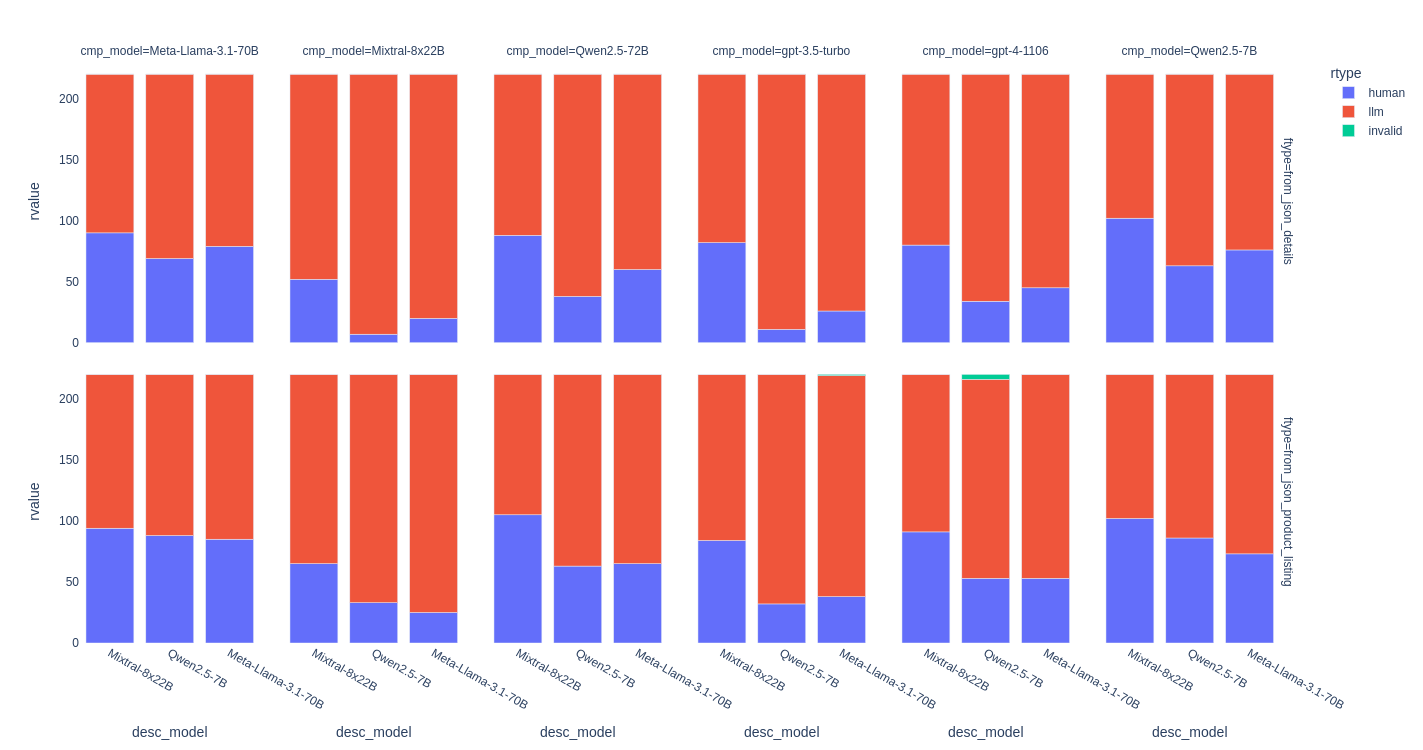

In [71]:
fig = px.bar(df, x="desc_model", y="rvalue", facet_col="cmp_model", facet_row="ftype", height=750, color="rtype")
fig.update_layout(
    plot_bgcolor="rgba(0, 0, 0, 0)",
)
# etype_order = {etype: i for i, etype in enumerate(df["cmp_model"].unique())}
# fig.update_xaxes(
#     tickvals=list(etype_order.values()),
#     ticktext=list(etype_order.keys()))

medal,nation,gold,silver,bronze
0,South Korea,24,13,11
1,China,10,15,8
2,Canada,9,12,12
